# TP of Lecture 3: Plug & Play Algorithms

<u>*Andrés Almansa - M2 MVA - Deep Learning for Image Restoration and Synthesis*</u>


In this practical session you will experiment with the Plug & Play ADMM and ISTA algorithms presented in the previous lecture, add a new inverse problem to that framework, and experimentally verify the validity of the convergence conditions and results that were presented in class.

As a reference for these results you can refer to the course slides[^1], the references therein, in particular the articles by Ryu *et al.* (2019) [^2] and by Xu *et al.* (2020)[^3].

### References

[^1]: Slides of lecture 3 under `supports-des-cours/3-Cours-PnP-optim/`.
Recall: course materials can be found following the [link](https://partage.imt.fr/index.php/s/GCDAsPxJkyB5LB6) and password you received by email, namely: `http://up5.fr/delires2025` with password `MVAdelires2025`.

[^2]: Ryu, E. K., Liu, J., Wang, S., Chen, X., Wang, Z., & Yin, W. (2019). Plug-and-Play Methods Provably Converge with Properly Trained Denoisers. In *ICML*.  [arXiv:1905.05406](http://arxiv.org/abs/1905.05406)

[^3]: Xu, X., Sun, Y., Liu, J., Wohlberg, B., & Kamilov, U. S. (2020). Provable Convergence of Plug-and-Play Priors with MMSE denoisers. [arXiv:2005.07685](http://arxiv.org/abs/2005.07685)

## Sending your report

When you are finished please upload your report here

http://up5.fr/delires2025-cr-tp3 which is an alias to

https://partage.imt.fr/index.php/s/cSWAENFE5gpGWck

You should upload a file with the following format `NAME-Surname-TP3.ext` where ext can be:

* pdf - for your report
* ipynb - for your jupyter notebook
* zip - if you hand in a single zip-file containing both the jupyter notebook and your pdf report

If you upload several times please add a trailing v1, v2, ... etc. before the extension, so that I can identify the latest version.

You have to hand-in your report by Tuesday January 28th. You will have to hand-in a report each week.

## Setup


To run this practical session (TP) you will need

* python3
* a few standard python packages like numpy, pytorch, script, matplotlib
* the code provided for this TP [^4]

For the python part you need access to a jupyter notebook server either on your local machine, on google colab or on a server provided by your university.

I recommend to use a notebook server that allows the use of a GPU to accelerate calls to the pytorch framework, like Google colab. It will ussually run the CNN-based denoisers much faster. This TP was tested on Google conal, and locally on machines with nvidia or Apple Silicon GPUs.

The specific code for this TP can be obtained (in its original version) from the author's GitHub site:

https://github.com/uclaopt/Provable_Plug_and_Play

A modified code that makes the implementation more modular and makes it easier to switch between CPU and GPU powered servers is available here [^4], along with the code needed to run the TV denoisers.

Download the notebook and upload it to your Google Drive. In the following we assume you uploaded to `Colab Notebooks/MVA-DELIRES-2025/`.

Then download the zip file PnP-TP.zip and unzip it into your Google Drive (same folder as you notebook). To do this you can mount your google drive on your computer, or you can unzip the file inside Google colab using the command `!unzip PnP-TP.zip` (see below).

Then go to your notebook and run the code below in order to have access to the python code in the zip file.

[^4]: Go to the main folder for course materials http://up5.fr/delires2025 and navigate to `supports-des-cours/3-Cours-PnP-optim/TP`. You should download two files: `PnP_TP.ipynb` and `PnP_TP.zip`.

### Mount Google Drive

Go to the folder in Google drive where you downloaded the provided code. Unzip `PnP-TP.zip` (unless you already did this on your computer). Go to PnP-TP and check its contents.

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Either unzip PnP-TP.zip on your mouted Google drive or do the following
# %cd /content/drive/My Drive/Colab Notebooks/MVA-DELIRES-2025/
# !unzip PnP-TP.zip
# Go to the unziped folder and check its contents
%cd /content/drive/My Drive/Colab Notebooks/Mva-delires/
!ls ./images
!ls ./utils
!ls -l

/content/drive/My Drive/Colab Notebooks/Mva-delires
barbara.tif  boats.tif	cameraman.tif  house.tif  lena256.tif  peppers.tif  simpson_nb512.png
config.py  psnr.py  __pycache__  utils.py
total 28
drwx------ 2 root root 4096 Jan 28 16:18 images
drwx------ 3 root root 4096 Jan 28 16:18 model
-rw------- 1 root root 3527 Dec  2  2020 optim.py
drwx------ 2 root root 4096 Jan 28 16:18 Pretrained_models
drwx------ 2 root root 4096 Jan 28 16:18 __pycache__
-rw------- 1 root root 1968 Jan 20  2020 pytorch_denoiser.py
-rw------- 1 root root 2085 Feb  6  2020 TV_denoiser.py
drwx------ 3 root root 4096 Jan 28 16:18 utils


### Check GPU

If a cuda GPU is not available, change the runtime type in the Runtime menu.

The following code checks if Apple Silicon or nvidia GPU is available.
In that case it sets `device` to "mps" or "cuda" respectively.
Otherwise fallback to `device="cpu"`.
If you have access to a TPU in google colab or another non-cuda GPU you may need to change the code below.

In [21]:
# Select best GPU, fallback to CPU if no GPU is available
import os, torch

# If Apple Silicon processor is available set device to "mps"
if torch.backends.mps.is_available():
    device = torch.device("mps")
# If nvidia GPU is available set device to "cuda"
elif torch.cuda.is_available():
    device = torch.device("cuda")
# otherwise fallback to "cpu"
else:
    device = torch.device("cpu")
    print("GPU not found using CPU.")

# device = torch.device("cpu")

device

device(type='cuda')

### Install required packages

In [22]:
! pip install tifffile
! pip install bm3d
from bm3d import bm3d, BM3DProfile

In [23]:
# Load BM3D denoiser


class BM3DDenoiser:
    def __init__(
        self,
        sigma=40,  # Noise stdev for an 8-bit image in [0,255]
        rescale=False,
    ):  # If true rescale [min,max] to [0,1] before applying denoiser
        self.sigma = sigma / 255.0
        self.rescale = rescale

    def denoise(self, xtilde):
        """
        Inputs:
            :xtilde     noisy image
        Outputs:
            :x          denoised image
        """
        # scale xtilde to be in range of [0,1] (for the clean image)
        if self.rescale:
            mintmp = np.min(xtilde)
            # mintmp = 0.0
            maxtmp = np.max(xtilde)
            # maxtmp = 255.0
            xtilde = (xtilde - mintmp) / (maxtmp - mintmp)

        # upgrade to 3D tensor
        xtildeBM3D = np.atleast_3d(xtilde)
        x = bm3d(xtildeBM3D, self.sigma)

        # rescale the denoised v back to original scale
        if self.rescale:
            x = x * (maxtmp - mintmp) + mintmp

        return x

## Preliminaries: test the denoisers


### Load input image

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

# Load clean image
# u_total = plt.imread('./images/simpson_nb512.png')
# u_total = tiff.imread('./images/cameraman.tif')
u_total = tiff.imread("./images/barbara.tif")

# Extract a small part
# u = np.zeros((256,256), dtype = np.float64)
# u = u_total[0:256, 0:256]
u = u_total  # [100:200,100:200]

# Normalize to [0,1]
maxval = 255.0
minval = 0
u = (u - minval) / (maxval - minval)

### Simulate noisy image

In [25]:
# Use always the same seed for random numbers for reproducibility
np.random.seed(42)

# Simulate noisy image
sigma255 = 40
sigma1 = sigma255 / 255.0
noise = np.random.normal(loc=0, scale=sigma1, size=(u.shape))
utilde = u + noise

# Show original and noisy images
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(u, cmap="gray", vmin=0, vmax=1)
ax1.set_title("Original image", fontsize=15)
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(utilde, cmap="gray", vmin=0, vmax=1)
ax2.set_title("Noisy image", fontsize=15)

Text(0.5, 1.0, 'Noisy image')

### Test TV and DnCNN denoisers

Load an input image and add random gaussian noise with $\sigma_{255}=40$, 15 or 5.

Byte-encoded *gray*-scale images take values in the range [0,255].

But denoising algorithms assume that clean images take values in the range [0,1].

So you need to first normalize your clean and noisy images and sigma values to the range [0,1]:

$u_1 = u_{255}/255$

$\sigma_1 = \sigma_{255}/255$

The DnCNN denoiser can be deployed as is, but for the TV denoising you need to choose the regularization parameter $\lambda$ in

$\hat{u}_\lambda = \arg\min_u \frac{1}{2}\|u-\tilde{u}\|^2 + \lambda TV(u)$

In [26]:
from TV_denoiser import TVDenoiser
from pytorch_denoiser import PyTorchDenoiser

# TV denoiser
TVlamb = sigma1**2
niter = 100
denoiser = TVDenoiser(TVlamb, niter)
uTV = denoiser.denoise(utilde)

# DnCNN denoiser
denoiser = PyTorchDenoiser("DnCNN", sigma255, cuda=True, rescale=False)
uDnCNN = denoiser.denoise(utilde)

#BM3D denoiser With the default settings.
denoiser = BM3DDenoiser(sigma255)
uBM3D = denoiser.denoise(utilde)

# Print performance and plot results
from utils.psnr import rmse, psnr

# printperf(residual, L2err) :
# -- prints out residual/sigma, rmse and psnr values
# peak=np.linalg.norm(u);
peak = 1.0
printperf = lambda residual, L2err: print(
    "residual/sigma={:.2f}\t RMSE={:.4f} ({:.1f} dB)".format(
        residual, L2err, 20 * np.log(peak / L2err) / np.log(10)
    )
)

print("TV Denoiser performance")
L2err = rmse(uTV, u)
residual = rmse(uTV, utilde)
printperf(residual / sigma1, L2err)

print("DnCNN Denoiser performance")
L2err = rmse(uDnCNN, u)
residual = rmse(uDnCNN, utilde)
printperf(residual / sigma1, L2err)

print('BM3D Denoiser performance')
L2err = rmse(uBM3D,u)
residual = rmse(uBM3D,utilde)
printperf(residual/sigma1, L2err)


# Show denoised images
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(uTV, cmap="gray", vmin=0, vmax=1)
ax1.set_title("TV denoising", fontsize=15)
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(uDnCNN, cmap="gray", vmin=0, vmax=1)
ax2.set_title("DnCNN denoising", fontsize=15)
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(uBM3D, cmap = 'gray', vmin=0, vmax = 1)
ax3.set_title('BM3D denoising', fontsize = 15)

TV Denoiser performance
residual/sigma=0.30	 RMSE=0.1197 (18.4 dB)
DnCNN Denoiser performance
residual/sigma=0.94	 RMSE=0.0450 (26.9 dB)
BM3D Denoiser performance
residual/sigma=0.95	 RMSE=0.0417 (27.6 dB)


Text(0.5, 1.0, 'BM3D denoising')

## Find optimal $\lambda$ for TV denoiser

The DnCNN denoiser can be deployed as is (for fixed pretrained noise values), but for the TV denoising you need to choose the regularization parameter $\lambda$ in

$\hat{u}_\lambda = \arg\min_u \frac{1}{2}\|u-\tilde{u}\|^2 + \lambda TV(u)$

Good values for $\lambda$ are usually between $\sigma$ and $\sigma^2$, but this really depends on the image contents: Total variation penalizes high frequency oscilatory patterns, so in those areas a smaller value of $\lambda$ may be required to preserve them.

A way to circumvent this problem is to systematically search for a value of $\lambda$ whose residual is close to the noise level:

$\|\hat{u}_\lambda - \tilde{u}\|^2 \approx \beta^2 \sigma^2 N$

To be conservative (we prefer to leave a bit of noise rather than removing details) we choose a value of $\beta < 1$ like $\beta=0.9$

At each iteration the value of $\lambda$ can be updated in the following manner:

$\lambda_{n+1} = \lambda_n e^{\rho(\sigma\beta - \|\hat{u}_{\lambda_n} - \tilde{u}\|/\sqrt{N})}$

This will increase or decrease $\lambda$ as needed to meet the residual constraint.

You can stop after 100 iterations or when the constraint is met up to 1% tolerance

> _**QUESTION 1**: Complete the code below as indicated_



Searching for optimal lambda for TV denoising
optimal lambda 0.10900195043305193
TV Denoiser performance
residual/sigma=0.30	 RMSE=0.1197 (18.4 dB)
DnCNN Denoiser performance
residual/sigma=0.94	 RMSE=0.0450 (26.9 dB)
BM3D Denoiser performance
residual/sigma=0.95	 RMSE=0.0417 (27.6 dB)
 RealSNDCC performance
residual/sigma=0.94	 RMSE=0.0448 (27.0 dB)


Text(0.5, 1.0, 'DnCNN denoising')

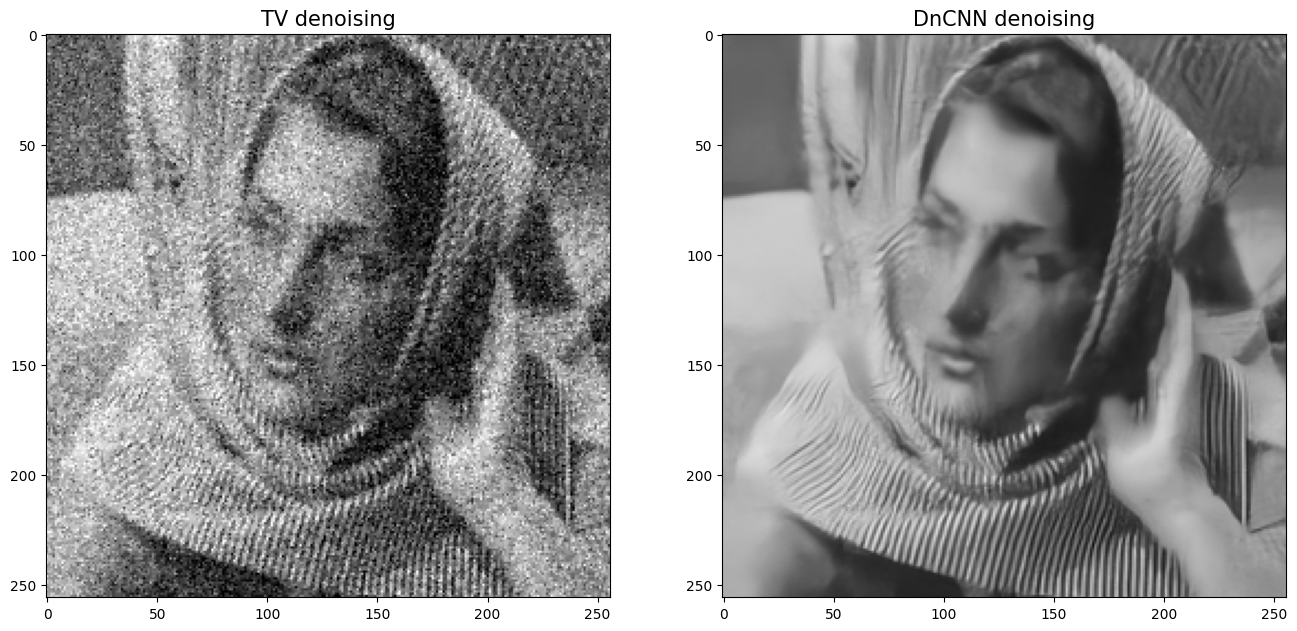

In [27]:
# Optimal lambda
print("Searching for optimal lambda for TV denoising")
TVlamb = sigma1**2
rho = 10
beta = 0.95
N = 255 * 255
for i in range(1, 20):
    uTV = TVDenoiser(lamb=TVlamb, niter=100).denoise(utilde)
    res = rmse(uTV, utilde)
    error = rmse(uTV, u)
    TVLamb=TVlamb*np.exp(rho*(sigma1*beta-res/np.sqrt(N)))
    # print('residual/sigma = {:.3f}\t rmse = {:.4e}\t lambda = {:.4e}'.format((res/sigma1),error,TVlamb))
    # print(" res/sigma = {:.3f} < rho = {:.3f} ?".format(res / sigma1, rho))
    # A way to circumvent this problem is to systematically search for a value of $\lambda$ whose residual is close to the noise level:

    stop_cond= i<100 and np.abs((sigma1*beta-res/np.sqrt(N))/(sigma1*beta)) <0.1

    if stop_cond:
        print("we breaked it")
        break

print("optimal lambda",TVLamb)
# Denoise
print("TV Denoiser performance")
denoiser = TVDenoiser(TVlamb, 100)
uTV = denoiser.denoise(utilde)
L2err = rmse(uTV, u)
residual = rmse(uTV, utilde)
printperf(residual / sigma1, L2err)

print("DnCNN Denoiser performance")
denoiser = PyTorchDenoiser("DnCNN", sigma255, cuda=True, rescale=False)
uDnCNN = denoiser.denoise(utilde)
L2err = rmse(uDnCNN, u)
residual = rmse(uDnCNN, utilde)
printperf(residual / sigma1, L2err)


print('BM3D Denoiser performance')
L2err = rmse(uBM3D,u)
residual = rmse(uBM3D,utilde)
printperf(residual/sigma1, L2err)

print(" RealSNDCC performance")
denoiser= PyTorchDenoiser('RealSN_DnCNN',sigma255,cuda=True,rescale=False)
uRealSN_DnCNN = denoiser.denoise(utilde)
L2err=rmse(uRealSN_DnCNN,u)
residual=rmse(uRealSN_DnCNN,utilde)
printperf(residual/sigma1,L2err)
# Show denoised images
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(uTV, cmap="gray", vmin=0, vmax=1)
ax1.set_title("TV denoising", fontsize=15)
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(uDnCNN, cmap="gray", vmin=0, vmax=1)
ax2.set_title("DnCNN denoising", fontsize=15)

> _**QUESTION 2**: Provide the optimal value of $\lambda$ and the RMSEs / PSNRs that you obtain for TV and the different PyTorch denoisers. Which denoiser provides the best performance?_

> _**QUESTION 3**: Is there a big difference between DnCNN and RealSN_DnCNN? Explain why or why not._



We found the optimal lambda to be 0.109,
TV got a rmse of 0.11 and a PSNR of 18.4 ,
DnCNN got a RMSE of 0.045 ( 26.9)
BM3D got a RMSE of 0.04 and a PSNR of 27.6
Real-SNDCCC got a RMSE of 0.044 and a PSNR of 27.0.

Question 3 : We don't have a big MSE difference between DnCNN and RealSN_DNCNN. First they do not depend on TVLambd which we have done an hyperparameters search before. Furthermore,  RealSN_DCNN and DCNN come from the same architecture and RealSN_DCNN seems to have small change in his architecture mainly

## Plug & Play ADMM / DRS for Gaussian denosing

### Introduction

### DRS (ADMM) Splitting Algorithm for Denoising Using DnCNN

In the previous section, we observed that TV denoising can be adapted to different values of $\sigma$ by varying the parameter $\lambda$. In contrast, the DnCNN denoiser is pretrained for three fixed noise levels, $\sigma \in \{5, 15, 40\}$. To extend its applicability, we will now implement a DRS (Alternating Direction Method of Multipliers, ADMM) splitting algorithm that can handle denoising at arbitrary noise levels, leveraging the pretrained DnCNN as a regularizer.

#### Problem Formulation

The algorithm solves inverse problems of the form:

$$
\xhat = \arg\min_\x F(\x) + \gamma G(\x)
$$

which can be equivalently rewritten as:

$$
\xhat = \arg\min_\x \alpha F(\x) + \sigma^2 G(\x), \quad \text{where } \gamma = \frac{\sigma^2}{\alpha}.
$$

Here:
- $F$ is a ($\mu$-strongly) convex data-fitting term.
- $G$ is a potentially non-convex regularization term, not necessarily known explicitly. However, we assume its associated proximal operator is well-approximated by the DnCNN denoiser:
  $$
  \prox_{\sigma^2 G}(\x) \approx D_\sigma(\x).
  $$

#### Plug & Play ADMM Algorithm

The algorithm iteratively updates the variables using the following steps:

1. **Denoising Step**:
   $$
   \x^{k+1} =
   \prox_{\sigma^2 G}(\y^k - u^k)
   $$

2. **Data-Fitting Step**:
   $$
   \y^{k+1} = \prox_{\alpha F}(\x^{k+1} + u^k),
   $$

3. **Dual Update**:
   $$
   u^{k+1} = u^k + \x^{k+1} - \y^{k+1}.
   $$

#### Convergence Conditions

According to Theorem 2 and Corollary 3, this algorithm converges under the following conditions:
1. The residual operator $D_\sigma - I$ is $L$-Lipschitz (or $L$-contractive) with $L < 1$.
2. The parameter $\alpha$ satisfies:
   $$
   \alpha \mu > \frac{L}{1 + L - 2L^2}.
   $$

This implementation provides a flexible framework for solving inverse problems using pretrained DnCNN denoisers as effective regularizers.


### Proximal operator for Gaussian denoising

For Gaussian denoising the data fitting term writes

$ F(\x) = \frac{1}{2 s^2}\| \x - \y \|^2 $

its proximal operator admits a closed form:

$ \prox_{\alpha F}(\x) = \arg\min_v \frac12 \|v - \x \|^2 + \alpha F(v)
= \frac{\x + \y * \alpha / s^2}{1+\alpha/s^2}$

>_**QUESTION 4**: Complete the following code to compute $\prox_{\alpha F}$ operator for Gaussian denoising._

In [28]:
# %% ---- define problem-specific proxF ----


def prox_datafit_gaussian_denoising(x, y, alpha, s):
    """
    Proximal Operator for Gaussian denoising:

    f(x) = || x - y ||^2 / (2 s^2)

    prox_{alpha f} (x) = (x + y*alpha/s^2)/(1+alpha/s^2)

    Parameters:
        :x - the argument to the proximal operator.
        :y - the noisy observation (flattened).
        :opts - the kwargs for hyperparameters.
            :alpha - the value of alpha.
            :s - the standard deviation of the gaussian noise in y.
    """
    a = alpha / (s**2)
    v = (x + y * a) / (1 + a)
    return v

### PnP DRS denoising experiment with $s = \sigma$

Now use the provided PnP DRS algorithm to denoise an image with noise variance $s^2 = \sigma^2$.

In this case you should use the regularization parameter $\gamma = 1$.

In [29]:
# @title set parameters & run denoisig experiment

sigma255 = 40  # @param [5, 15, 40] {type:"raw"}
gamma = 1.0  # @param {type:"number"}
maxitr = 20  # @param {type:"slider", min:10, max:100, step:10}

# ---- Regularization model prox_{sigma^2 G} = denoise ----
# noise level
# sigma255 = 40             # for uint8 images
sigma1 = sigma255 / 255.0  # for images normalized in [0,1]
# load pretrained denoiser NN model into Denoiser object
model_type = (
    "RealSN_DnCNN"  # Alternatives: DnCNN/ SimpleCNN / RealSN_DnCNN / RealSN_SimpleCNN
)
sigma = sigma255  # Alternatives: 5, 15, 40
cuda = True  # If true use pytorch cuda optimisations
rescale = False  # If true rescale [min,max] to [0,1] before applying denoiser
Denoiser = PyTorchDenoiser(model_type, sigma, cuda, rescale)
# define denoise(x) function (as a call to the Denoiser object)
denoise = lambda x: Denoiser.denoise(x)

# ADMM / DRS parameters
# gamma = 1.0                       # Regularization parameter
alpha = sigma1**2 / gamma
# maxitr = 20                     # ADMM max number of iterations
# Monitors
verbose = 1  # display debugging messages
from optim import drs, GaussianMonitor

monitor = GaussianMonitor(u)  # ground truth is only used
# to track PSNR during iterations

# Set noise variance s^2 equal to denoiser variance sigma^2
s = sigma1

# Datta fitting : prox_{alpha F}
proxF = lambda x: prox_datafit_gaussian_denoising(x, utilde, alpha, s)


# optional PnP DRS/ADMM parameters
opts = dict(maxitr=maxitr, verbose=verbose, monitor=monitor)


# ---- simulate noisy image ----
np.random.seed(42)  # Use always the same seed for reproducibility
s = sigma1
noise = np.random.normal(loc=0, scale=s, size=(u.shape))
utilde = u + noise


# Start the algorithm
# start = time.time()
init = utilde
# init = np.random.normal(loc=0.5, scale=0.5, size=(noisy.shape))
out = drs(proxF, denoise, init, **opts)
# out = admm(proxF,denoise,init,**opts)
# end = time.time()
# print(end-start)

# %% ---- plot result ----
fig = plt.figure(figsize=(32, 32))
ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(u, cmap="gray", vmin=0, vmax=1)
ax1.set_title("Original image", fontsize=30)

ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(utilde, cmap="gray", vmin=0, vmax=1)
ax2.set_title("Noisy image (PSNR ={0:.2f})".format(psnr(u, utilde)), fontsize=30)

ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(out, cmap="gray", vmin=0, vmax=1)
ax3.set_title(
    r"Restored image, (PSNR ={0:.2f}, niter={1})".format(psnr(u, out), maxitr),
    fontsize=30,
)

ax4 = fig.add_subplot(2, 2, 4)
p = ax4.imshow(out - u, cmap="gray")
plt.colorbar(p, orientation="vertical")
_ = ax4.set_title(r"Error, (PSNR ={0:.2f})".format(psnr(u, out)), fontsize=30)

i = 1,	 psnr = 26.965323076946888,	 fpr = 0.1476031408975729
i = 2,	 psnr = 26.965323076946888,	 fpr = 0.07380157044878645
i = 3,	 psnr = 26.965323076946888,	 fpr = 0.036900785224393225
i = 4,	 psnr = 26.965323076946888,	 fpr = 0.018450392612196612
i = 5,	 psnr = 26.965323076946888,	 fpr = 0.009225196306098306
i = 6,	 psnr = 26.965323076946888,	 fpr = 0.004612598153049153
i = 7,	 psnr = 26.965323076946888,	 fpr = 0.0023062990765245765
i = 8,	 psnr = 26.965323076946888,	 fpr = 0.0011531495382622883
i = 9,	 psnr = 26.965323076946888,	 fpr = 0.0005765747691311441
i = 10,	 psnr = 26.965323076946888,	 fpr = 0.00028828738456557207
i = 11,	 psnr = 26.965323076946888,	 fpr = 0.00014414369228278603
i = 12,	 psnr = 26.965323076946888,	 fpr = 7.207184614139303e-05
i = 13,	 psnr = 26.965323076946888,	 fpr = 3.603592307069651e-05
i = 14,	 psnr = 26.965323076946888,	 fpr = 1.8017961535348254e-05
i = 15,	 psnr = 26.965323076946888,	 fpr = 9.008980767674134e-06
i = 16,	 psnr = 26.965323076946888,	 fpr

### PnP DRS denoising experiment with $s \neq \sigma$

Now use the provided PnP DRS algorithm to denoise an image with noise variance $s^2 \neq \sigma^2$.

In this case the regularization parameter $\gamma$ needs to be adapted to find the optimal value.

>_**QUESTION 5:** Take $s=30$ and use the same strategy as for TV denoising to search for the optimal $\gamma$ for $\sigma=5, 15, 40$. Make a table with the optimal values of $\gamma$ for each $\sigma$ and the corresponding PSNRs._
1. _What is the maximum value of $\gamma$ that ensures convergence?_
2. _Is convergence guaranteed in all cases? Which ones?_
3. _Which value of $\sigma$ provides the best results? Can you explain why?_

A partial answer to the convergence analysis is provided in the cell below

>_**QUESTION 6:** Compare the results obtained with RealSN_DnCNN and with DnCNN, TV and BM3D. Which one provides the best performance? Can you explain why?_

>_**QUESTION 7:** Test different initialisations, including 0 and random images. How important is the initialization to obtain a good result? Is this consistent with the convergence results seen in the Lecture ?_


| $\sigma$ | $\gamma$ | PSNR |
| -------- | -------- | ---- |
| 5 | 2.6 | 16.4 dB |
| -------- | -------- | ---- |
| 15 | 8 |13.6 DB |
| -------- | -------- | ---- |
| 40 | 21 | 13.3 dB |


Question 5: find the optimal gamma:

In [30]:
# u = normalized input image (defined above)

# ---- Degradation model F (white gaussian noise) ----
s = 30.0
s1 = s / (maxval - minval)
np.random.seed(42)
noise = np.random.normal(loc=0, scale=s1, size=(u.shape))
utilde = u + noise


# ---- Regularization model prox_{sigma^2 G} = denoise ----
# Denoiser noise level - Alternatives: 5, 15, 40
sigma255 = 5  # for uint8 images
sigma1 = sigma255 / 255.0  # for images normalized in [0,1]
# load pretrained denoiser NN model into Denoiser object
model_type = (
    "RealSN_DnCNN"  # Alternatives: DnCNN/ SimpleCNN / RealSN_DnCNN / RealSN_SimpleCNN
)
sigma = sigma255  # Alternatives: 5, 15, 40
cuda = True  # If true use pytorch cuda optimisations
rescale = False  # If true rescale [min,max] to [0,1] before applying denoiser
# pytorch deoiser
Denoiser = PyTorchDenoiser(model_type, sigma, cuda, rescale)
# define denoise(x) function (as a call to the Denoiser object)
denoise = lambda x: Denoiser.denoise(x)


# ADMM / DRS parameters
gamma = sigma1 / s1  # Regularization parameter
alpha = sigma1**2 / gamma
maxitr = 100  # ADMM max number of iterations
# Monitors
verbose = 0  # display debugging messages

proxF = lambda x: prox_datafit_gaussian_denoising(x, utilde, alpha, s1)


# COMPLETE THE CODE
# find optimal gamma
# compute out = result of PnP ADMM denoising
# repeat for sigma255 = 40, 15, 5$
opts = dict(maxitr=maxitr, verbose=0, monitor=monitor)

# begin ANSWER
# ...
sigma_values = [5, 15, 40]
optimal_results = {}
num_itr=10
N=255*255
for sigma255 in sigma_values:
    optimal_value = -np.inf
    print("we are doing sigma ",sigma255)
    sigma1 = sigma255 / 255.0
    denoiser = PyTorchDenoiser(model_type, sigma255, cuda, rescale)
    # Define PnP DRS components
    denoise = lambda x: denoiser.denoise(x)
    # Monitor for optimal gamma search
    opts = dict(maxitr=maxitr, verbose=0, monitor=None)
    for i in range(num_itr):
        print("i",i)
        s1= sigma1/gamma
        alpha = sigma1**2 / gamma

        proxF = lambda x: prox_datafit_gaussian_denoising(x, utilde, alpha, s1)

        # Plug and Play Denoising
        out = drs(proxF, denoise, utilde, **opts)

        # Compute PSNR for the result
        psnr_value = psnr(u, out)
        if psnr_value > optimal_value:
            optimal_results[sigma255] = (gamma, psnr_value)
        # update gamma
        res= rmse(out, utilde)

        gamma = gamma*np.exp(rho*(sigma1*beta-res/np.sqrt(N)))
        stop_cond= i<num_itr and np.abs((sigma1*beta-res/np.sqrt(N))/(sigma1*beta)) <0.1
        if stop_cond:
          break
    print(
        "for sigma255 = ",
        sigma255,
        " optimal gamma = ",
        optimal_results[sigma255][0],
        " PSNR = ",
        optimal_results[sigma255][1],
    )


# end ANSWER

# ---- optional ADMM parameters ----
monitor = GaussianMonitor(u)
opts = dict(maxitr=maxitr, verbose=1, monitor=monitor)

# %% ---- plug and play !!!! ----
out = drs(proxF, denoise, utilde, **opts)
# out = admm(proxF,denoise,utilde,**opts)


# %% ---- plot result ----
fig = plt.figure(figsize=(32, 32))
ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(u, cmap="gray", vmin=0, vmax=1)
ax1.set_title("Original image", fontsize=30)

ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(utilde, cmap="gray", vmin=0, vmax=1)
ax2.set_title("Noisy image (PSNR ={0:.2f})".format(psnr(u, utilde)), fontsize=30)

ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(out, cmap="gray", vmin=0, vmax=1)
ax3.set_title(
    r"Restored image, (PSNR ={0:.2f}, niter={1})".format(psnr(u, out), maxitr),
    fontsize=30,
)

ax4 = fig.add_subplot(2, 2, 4)
p = ax4.imshow(out - u, cmap="gray")
plt.colorbar(p, orientation="vertical")
_ = ax4.set_title(r"Error, (PSNR ={0:.2f})".format(psnr(u, out)), fontsize=30)

we are doing sigma  5
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
for sigma255 =  5  optimal gamma =  0.8868881060414456  PSNR =  13.609635678396906
we are doing sigma  15
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
for sigma255 =  15  optimal gamma =  162.8764305016645  PSNR =  13.3501539422424
we are doing sigma  40
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
for sigma255 =  40  optimal gamma =  189242704.2287742  PSNR =  13.485584778847297
i = 1,	 psnr = 26.900140264936784,	 fpr = 0.12160918957451623
i = 2,	 psnr = 17.872489590085635,	 fpr = 0.044800481389855144
i = 3,	 psnr = 18.433068944367548,	 fpr = 0.020209595347058552
i = 4,	 psnr = 18.726580511610408,	 fpr = 0.012868834583432366
i = 5,	 psnr = 18.379865008772587,	 fpr = 0.011369768104817476
i = 6,	 psnr = 18.72977983195331,	 fpr = 0.011767432273726168
i = 7,	 psnr = 18.341641199977147,	 fpr = 0.012684844174334612
i = 8,	 psnr = 18.725669578578415,	 fpr = 0.013315452591624406
i = 9,	 psnr = 18.318799421390313,	 fpr = 0.013754708957827835



>_**QUESTION 6:** Compare the results obtained with RealSN_DnCNN and with DnCNN, TV and BM3D. Which one provides the best performance? Can you explain why?_

The best results are obtained with RealSN_DCNN and DnCNN ( PSNR around 14.0). We suspect that they have been trained with such modality and therefore perform better


In [ ]:
# u = normalized input image (defined above)

# ---- Degradation model F (white gaussian noise) ----
s = 30.0
s1 = s / (maxval - minval)
np.random.seed(42)
noise = np.random.normal(loc=0, scale=s1, size=(u.shape))
utilde = u + noise


# ---- Regularization model prox_{sigma^2 G} = denoise ----
# Denoiser noise level - Alternatives: 5, 15, 40
sigma255 = 5  # for uint8 images
sigma1 = sigma255 / 255.0  # for images normalized in [0,1]
# load pretrained denoiser NN model into Denoiser object
model_type = (
    "RealSN_DnCNN"  # Alternatives: DnCNN/ SimpleCNN / RealSN_DnCNN / RealSN_SimpleCNN
)
sigma = sigma255  # Alternatives: 5, 15, 40
cuda = True  # If true use pytorch cuda optimisations
rescale = False  # If true rescale [min,max] to [0,1] before applying denoiser
# pytorch deoiser
Denoiser = PyTorchDenoiser(model_type, sigma, cuda, rescale)
# define denoise(x) function (as a call to the Denoiser object)
denoise = lambda x: Denoiser.denoise(x)


# ADMM / DRS parameters
gamma = sigma1 / s1  # Regularization parameter
alpha = sigma1**2 / gamma
maxitr = 100  # ADMM max number of iterations
# Monitors
verbose = 0  # display debugging messages

proxF = lambda x: prox_datafit_gaussian_denoising(x, utilde, alpha, s1)


# COMPLETE THE CODE
# find optimal gamma
# compute out = result of PnP ADMM denoising
# repeat for sigma255 = 40, 15, 5$
opts = dict(maxitr=maxitr, verbose=0, monitor=monitor)

# begin ANSWER
# ...

list_denoiser = ["RealSN_DnCNN", "DnCNN"] #TV
for model_type in list_denoiser:
    sigma1 = sigma255 / 255.0
    denoiser = PyTorchDenoiser(model_type, sigma255, cuda, rescale)
    # Define PnP DRS components
    denoise = lambda x: denoiser.denoise(x)
    # Monitor for optimal gamma search
    opts = dict(maxitr=maxitr, verbose=0, monitor=None)

    gamma = sigma1 / s1
    alpha = sigma1**2 / gamma

    proxF = lambda x: prox_datafit_gaussian_denoising(x, utilde, alpha, s1)

    # Plug and Play Denoising
    out = drs(proxF, denoise, utilde, **opts)
    psnr_value = psnr(u, out)

    # %% ---- plot result ----
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.imshow(out, cmap="gray", vmin=0, vmax=1)
    ax3.set_title(
        r"Restored image, (PSNR ={0:.2f}, niter={1}, for model {2})".format(
            psnr(u, out), maxitr, model_type
        ),
        fontsize=30,
    )

    ax4 = fig.add_subplot(2, 2, 4)
    p = ax4.imshow(out - u, cmap="gray")
    plt.colorbar(p, orientation="vertical")
    _ = ax4.set_title(r"Error, (PSNR ={0:.2f})".format(psnr(u, out)), fontsize=30)


denoiser = BM3DDenoiser(sigma255)
# Define PnP DRS components
denoise = lambda x: denoiser.denoise(x)
# Monitor for optimal gamma search
opts = dict(maxitr=maxitr, verbose=0, monitor=None)

gamma = sigma1 / s1
alpha = sigma1**2 / gamma

proxF = lambda x: prox_datafit_gaussian_denoising(x, utilde, alpha, s1)

# Plug and Play Denoising
out = drs(proxF, denoise, utilde, **opts)
psnr_value = psnr(u, out)
model_type="bm3D"
# %% ---- plot result ----
ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(out, cmap="gray", vmin=0, vmax=1)
ax3.set_title(
    r"Restored image, (PSNR ={0:.2f}, niter={1}, for model {2})".format(
        psnr(u, out), maxitr, model_type
    ),
    fontsize=30,
)

ax4 = fig.add_subplot(2, 2, 4)
p = ax4.imshow(out - u, cmap="gray")
plt.colorbar(p, orientation="vertical")
_ = ax4.set_title(r"Error, (PSNR ={0:.2f})".format(psnr(u, out)), fontsize=30)




# Add TV
sigma1 = sigma255 / 255.0
TVlamb = sigma1**2
denoiser = TVDenoiser(TVlamb, niter)
# Define PnP DRS components
denoise = lambda x: denoiser.denoise(x)
# Monitor for optimal gamma search
opts = dict(maxitr=maxitr, verbose=0, monitor=None)

gamma = sigma1 / s1
alpha = sigma1**2 / gamma


proxF = lambda x: prox_datafit_gaussian_denoising(x, utilde, alpha, s1)


# Plug and Play Denoising
out = drs(proxF, denoise, utilde, **opts)
psnr_value = psnr(u, out)
# %% ---- plot result ----
fig = plt.figure(figsize=(32, 32))

ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(utilde, cmap="gray", vmin=0, vmax=1)
ax2.set_title("Noisy image (PSNR ={0:.2f})".format(psnr(u, utilde)), fontsize=30)

ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(out, cmap="gray", vmin=0, vmax=1)
ax3.set_title(
    r"Restored image, (PSNR ={0:.2f}, niter={1}, for model Total Variation )".format(
        psnr(u, out), maxitr
    ),
    fontsize=30,
)

ax4 = fig.add_subplot(2, 2, 4)
p = ax4.imshow(out - u, cmap="gray")
plt.colorbar(p, orientation="vertical")
_ = ax4.set_title(r"Error, (PSNR ={0:.2f})".format(psnr(u, out)), fontsize=30)

# Compute PSNR for the result

# end ANSWER

# add BM3D
denoiser = BM3DDenoiser(sigma255)
sigma1 = sigma255 / 255.0
TVlamb = sigma1**2

# Define PnP DRS components
denoise = lambda x: denoiser.denoise(x)
# Monitor for optimal gamma search
opts = dict(maxitr=maxitr, verbose=0, monitor=None)

gamma = sigma1 / s1
alpha = sigma1**2 / gamma


proxF = lambda x: prox_datafit_gaussian_denoising(x, utilde, alpha, s1)


# Plug and Play Denoising
out = drs(proxF, denoise, utilde, **opts)
psnr_value = psnr(u, out)

# %% ---- plot result ----
fig = plt.figure(figsize=(32, 32))

ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(utilde, cmap="gray", vmin=0, vmax=1)
ax2.set_title("Noisy image (PSNR ={0:.2f})".format(psnr(u, utilde)), fontsize=30)

ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(out, cmap="gray", vmin=0, vmax=1)
ax3.set_title(
    r"Restored image, (PSNR ={0:.2f}, niter={1}, for model Total Variation )".format(
        psnr(u, out), maxitr
    ),
    fontsize=30,
)

ax4 = fig.add_subplot(2, 2, 4)
p = ax4.imshow(out - u, cmap="gray")
plt.colorbar(p, orientation="vertical")
_ = ax4.set_title(r"Error, (PSNR ={0:.2f})".format(psnr(u, out)), fontsize=30)

# Compute PSNR for the result
# end ANSWER

/content/drive/My Drive/Colab Notebooks/Mva-delires/utils/utils.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))
<ipython-input-3

>_**QUESTION 7:** Test different initialisations, including 0 and random images. How important is the initialization to obtain a good result? Is this consistent with the convergence results seen in the Lecture ?_



In [ ]:

def drsbis(proxF,proxG,init,**opts):
    """
    Douglas Rachford Splitting (notation differs from Ryu's paper as follows)
    zk     = x_old + u_old
    xk+1/2 = v
    xk+1   = x
    """

    """ Process parameters. """
    maxitr = opts.get('maxitr', 50)
    verbose = opts.get('verbose', 1)
    monitor  = opts.get('monitor', None)  # debugging messages


    """ Initialization. """

    n = init.size  # == np.prod(init.shape), i.e. number of elements in ndarray

    x = np.copy(init)
    v = np.zeros_like(init, dtype=np.float64)
    u = np.zeros_like(init, dtype=np.float64)

    """ Main loop. """

    for i in range(maxitr):

        # record the variables in the current iteration
        x_old = np.copy(x)
        v_old = np.copy(v)
        u_old = np.copy(u)

        """ proximal step. """

        v = proxF(x+u)
        # prox_poisson_datafit(x+u,noisy,lam)

        """ denoising step. """

        xtilde = np.copy(2*v - x_old - u_old)
        #x = denoiser(np.reshape(xtilde, (m,n)))
        #x = np.reshape(x, -1)
        x = proxG(xtilde)

        """ dual update """

        u = np.copy(u_old + x_old - v)

        """ Monitors """

        if verbose and not (monitor is None) :
            monitor.drs_iter(i,x,v,u,x_old,v_old,u_old)

    """ Get restored image. """
    #x = np.reshape((x) , (m, n))
    return x
#TODO: implémenter pour différente initialization.

### Check convergence conditions


The PnP-ADMM algorithm for minimizing $\alpha F(x) + \sigma^2 G(x)$ is guaranteed to converge to a fixed point as long as:
* $F$ is $\mu$-strongly convex
* $Lip(I-D) = L < 1$ where $D=\prox_{\sigma^2 G}$ is the denoiser
* The regularization parameter $\gamma = \sigma^2/\alpha$ satisfies
$$ \gamma < \mu \sigma^2 \frac{1+L - 2 L^2}{L}$$

For the denoising problem we have
$$ F(x) = \frac{\|x - y\|^2}{2s^2} $$

**Find the maximal value of $\mu$ such that $F$ is $\mu$ strongly convex**

$F$ is $\mu$-strongly convex iff $\nabla^2 F - \mu Id$ is positive semidefinite, i.e. iff $(\frac{1}{s^2}-\mu)Id$ posite semidefinite. $\mu = \frac{1}{s^2}$

The _estimated_ value of $Lip(I-D) = L$ for the different denoisers is, according to Ryu(2019, Figure 1)

| $D$   | $L$ |
| ----- | ---------- |
| RealSN_DnCNN | 0,464 |
| DnCNN | 0,484 |
| BM3D  | 1,198 |

You can write a variant of the DRS algorithm which tracks the expansion factor at each iteration of the of the PnP-DRS algorithm.
Let $T$ be the operator that computes one iteration of PnP-DRS.

$$ u_{k+1} = T(u_k) $$

The algorithm converges to a fixed point $u^*$ if $T(u^*)=u^*$.
This convergence is ensures as long as $T$ is nonexpansive meaning that

$$ \|T(x) - T(y)\| \leq \varphi \|x-y\| \quad \forall x, y \quad \text{ and } \varphi <1 $$

The expansion factor $\varphi$ can be estimated as the maximal value of

$$ \varphi_k = \|T(x_k) - T(x_{k-1}) \| / \|x_k - x_{k-1}\| $$

$x_k = T(x_{k-1})$

complete the code below to output an array factors with these estimates



In [ ]:
def drs2(proxF, proxG, init, **opts):
    """
    Douglas Rachford Splitting (notation differs from Ryu's paper as follows)
    zk     = x_old + u_old
    xk+1/2 = v
    xk+1   = x
    This variant tracks the contraction factors at each iteration
    """

    """ Process parameters. """
    maxitr = opts.get("maxitr", 50)
    verbose = opts.get("verbose", 1)
    monitor = opts.get("monitor", None)  # debugging messages

    """ Initialization. """

    n = init.size  # == np.prod(init.shape), i.e. number of elements in ndarray

    x = np.copy(init)
    v = np.zeros_like(init, dtype=np.float64)
    u = np.zeros_like(init, dtype=np.float64)
    x_old = np.zeros_like(init, dtype=np.float64)

    factors = np.zeros([maxitr - 1], dtype=np.float64)

    """ Main loop. """

    for i in range(maxitr):
        # record the variables in the current iteration
        x_older = np.copy(x_old)
        x_old = np.copy(x)
        v_old = np.copy(v)
        u_old = np.copy(u)

        """ proximal step. """

        v = proxF(x + u)
        # prox_poisson_datafit(x+u,noisy,lam)

        """ denoising step. """

        xtilde = np.copy(2 * v - x_old - u_old)
        # x = denoiser(np.reshape(xtilde, (m,n)))
        # x = np.reshape(x, -1)
        x = proxG(xtilde)

        """ dual update """

        u = np.copy(u_old + x_old - v)

        """ Monitors """

        if verbose and not (monitor is None):
            monitor.drs_iter(i, x, v, u, x_old, v_old, u_old)

        if i > 0:
            factors[i - 1] = np.linalg.norm(x - x_old) / np.linalg.norm(x_old - x_older)

    """ Get restored image. """
    # x = np.reshape((x) , (m, n))
    return x, factors


# u = normalized input image (defined above)

# ---- Degradation model F (white gaussian noise) ----
s = 30.0
s1 = s / (maxval - minval)
np.random.seed(42)
noise = np.random.normal(loc=0, scale=s1, size=(u.shape))
utilde = u + noise


# ---- Regularization model prox_{sigma^2 G} = denoise ----
# noise level
sigma255 = 15  # for uint8 images
sigma1 = sigma255 / 255.0  # for images normalized in [0,1]
# load pretrained denoiser NN model into Denoiser object
model_type = (
    "RealSN_DnCNN"  # Alternatives: DnCNN/ SimpleCNN / RealSN_DnCNN / RealSN_SimpleCNN
)
# model_type = "DnCNN"     # Alternatives: DnCNN/ SimpleCNN / RealSN_DnCNN / RealSN_SimpleCNN
sigma = sigma255  # Alternatives: 5, 15, 40
cuda = True  # If true use pytorch cuda optimisations
rescale = False  # If true rescale [min,max] to [0,1] before applying denoiser
# Pytorch denoiser
Denoiser = PyTorchDenoiser(model_type, sigma, cuda, rescale)
# BM3D denoiser
# Denoiser = BM3DDenoiser(sigma255)
# define denoise(x) function (as a call to the Denoiser object)
denoise = lambda x: Denoiser.denoise(x)


# ADMM / DRS parameters
gamma0 = sigma1 / s1  # Regularization parameter
alpha = sigma1**2 / gamma
maxitr = 20  # ADMM max number of iterations
# Monitors
verbose = 0  # display debugging messages

proxF = lambda x: prox_datafit_gaussian_denoising(x, noisy, alpha, s1)


# Maximal (theoretical) gamma
mu = 1.0 / (s1**2)
eps = 0.464  # RealSN_DnCNN
# eps = 1.198 # BM3D
gamma_max = mu * (sigma1**2) * (1.0 + eps - 2 * (eps**2)) / eps

# geometric mean
gmean = lambda a: np.exp(np.mean(np.log(a)))

init = utilde
print("Theoretical gamma max = {:.3e}".format(gamma_max))
# test a few gammas around the approximately optimal gamma
for factor in np.geomspace(1 / 4, 16, num=10):
    gamma = gamma0 * factor
    alpha = sigma1**2 / gamma
    opts = dict(maxitr=maxitr, verbose=0, monitor=None)
    # Datta fitting : prox_{alpha F}
    proxF = lambda x: prox_datafit_gaussian_denoising(x, utilde, alpha, s1)
    out, factors = drs2(proxF, denoise, init, **opts)
    res = rmse(out, utilde)
    error = rmse(out, u)
    gamma = gamma * np.exp(rho * (s1 * beta - res))
    print(
        "residual/sigma = {:.3f}\t rmse = {:.3e}\t gamma = {:.3e}\t max eps = {:.2f}\t mean eps = {:.2f}".format(
            (res / s1), error, gamma, np.max(factors), gmean(factors)
        )
    )
    stop_cond = np.abs(s1 * beta - res) < s1 * 0.005
    if stop_cond:
        break

### PnP ADMM algorithm

>_**QUESTION 8:**_
>
>_a) write the ADMM algorithm to solve $\xhat = \arg\min_\x F(\x) + G(\x)$ given the proximal operators of $F$ and $G$. (You can use the provided Douglas Rachford algorithm, which is very similar and equivalent to ADMM, or the code squeleton below)._
>
>_b) A renaming of variables with a reordering of the three updates allows to show the equivalence of ADMM and DRS. Prove this equivalence._




In [ ]:
def admm(proxF, proxG, init, **opts):
    """
    ADMM - min_x F(x) + G(x) by ADMM splitting
    Inputs:
        :proxF      Proximal operator of F
        :proxG      Proximal operator of G
        :init       Initial value of x
    Optional inputs
        :maxitr     default 50
        :verbose    default 1 (show messages)
        :monitor    default None
    Outputs
        :x          minimizer
    """

    """ Process parameters. """
    maxitr = opts.get("maxitr", 50)
    verbose = opts.get("verbose", 1)
    monitor = opts.get("monitor", None)  # debugging messages

    """ Initialization. """

    n = init.size  # == np.prod(init.shape), i.e. number of elements in ndarray

    y = np.copy(init)
    x = np.zeros_like(init, dtype=np.float64)
    u = np.zeros_like(init, dtype=np.float64)

    """ Main loop. """

    for i in range(maxitr):
        # record the variables in the current iteration
        x_old = np.copy(x)
        y_old = np.copy(y)
        u_old = np.copy(u)

        """ denoising step. """

        # COMPLETE THIS CODE
        x = proxG(y_old - u_old)

        """ proximal step. """
        y = proxF(x + u_old)
        # COMPLETE THIS CODE

        """ dual update """
        u = u_old + x - y
        # COMPLETE THIS CODE

        """ Monitors """

        if verbose and not (monitor is None):
            monitor.admm_iter(i, x, y, u, x_old, y_old, u_old)

    """ Get restored image. """
    return x

b) We rename with the following convention from Douglas Rachford to ADMM:
we keep u  and x as the same name, and y as v. In this case  we have the same proximal step  and the dual update. Only the desoising is different.

## Missing Pixels

Another common inverse problem is missing pixels where the observation model is

$$ y_i = m_i x_i + n_i$$

where $m_i \sim \operatorname{Ber}(p)$ is known
and $n_i \sim \mathcal{N}(0,s^2)$ is unknown.

For a random selection of $p=10\%$ of the pixels $m_i=1$ and the pixel value $x_i$ is corrupted by white gaussian noise with a small variance $s^2$.
For the remaining $90\%$ of the pixels $x_i$ is completely unknown.

>_**QUESTION 9:** Write the potential and the proximal operator for this degradation (it has a closed form), and solve the inverse problem using PnP-ADMM as before._

We have that $$ y_i \sim \mathcal{N}(m_i x_i ,s^2)$$,
therefore the probability distribution of $y_i$ is $ \frac{1}{\sqrt{2 pi s^2}} exp((y_i-m_i x_i)^2/s^2) $. Taking the log and as s^2 is
azesupposed to be known, we have  the potential to be
$$
  || M*x - y ||^2 / (2s^2) + 1/2 * (ln(2*pi*s^2))
$$
Based on the formula described [here](https://pages.saclay.inria.fr/emilie.chouzenoux/ECP/Slides/cours_ECP_prox.pdf) (page 39),
the corresponding proximal is
$$
prox_f(u)=(id+M^TM)^{-1}(u+M^T y )  
$$


In [ ]:
# %% ---- define problem-specific proxF ----


def prox_datafit_inpainting(x, y, mask, alpha, s):
    """
    Proximal Operator for Gaussian denoising:

    f(x) = || M*x - y ||^2 / (2 s^2)

    prox_{alpha f} (x[i]) = (x[i]*s^2 + y[i]*alpha)/(s^2+alpha) if M[i]==1
                          = x[i]                                if M[i]==0

    Parameters:
        :x - the argument to the proximal operator.
        :y - the noisy observation.
        :mask - binary image of the same size as x
        :opts - the kwargs for hyperparameters.
            :alpha - the value of alpha.
            :s - the standard deviation of the gaussian noise in y.
    """
    s2 = s**2
    # v = ... # COMPLETE this code
    N = x.shape[0]
    v = np.zeros(N)
    for i in range(N):
        if mask[i] == 1:
            v[i] = (x[i] * s2 + y[i] * alpha) / (s2 + alpha)
        else:
            v[i] = x[i]
    return v


# %% ---- define problem-specific monitor ----
import time

# from skimage.measure import compare_psnr
from utils.psnr import rmse, psnr


class InpaintingMonitor:
    def __init__(self, clean, mask, sigma):
        self.clean = clean
        self.mask = mask
        self.sigma = sigma

    def drs_iter(self, i, x, v, u, x_old, v_old, u_old):
        fpr = np.sqrt(np.sum(np.square((x + u - x_old - u_old))) / x.size)
        error_in_mask = np.sqrt(
            np.sum(np.square(mask * (x - self.clean))) / (np.sum(mask))
        )
        psnrs = psnr(x, self.clean, 1.0)
        if i % 50 == -1 % 50:
            print(
                "i = {},\t psnr = {:.2f}, fpr = {:.2f}, error in mask = {:.2f}".format(
                    i + 1, psnrs, fpr, error_in_mask
                )
            )

    admm_iter = drs_iter


# COMPLETE THIS CODE
# load image u
# simulate degraded image utilde (noise with standard deviation $s = 1/255$)
# restore u with PnP ADMM seeking for the optimal \gamma
u = tiff.imread("./images/barbara.tif")
maxval = 255.0
minval = 0
u = (u - minval) / (maxval - minval)
# simulate degraded image utilde (noise with standard deviation $s = 1/255$)
s = 1 / 255
np.random.seed(42)
noise = np.random.normal(loc=0, scale=s, size=(u.shape))
utilde = u + noise
# create the mask
mask = np.random.rand(u.size) > 0.5
mask = mask.astype(np.float64)
mask = mask.reshape(u.shape)

utilde = utilde * mask

monitor = InpaintingMonitor(u, mask, sigma1)


# %% ---- plot result ----
fig = plt.figure(figsize=(32, 32))
ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(u, cmap="gray", vmin=0, vmax=1)
ax1.set_title("Original image", fontsize=30)

ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(utilde, cmap="gray", vmin=0, vmax=1)
ax2.set_title("Degraded image (PSNR ={0:.2f})".format(psnr(u, utilde)), fontsize=30)

ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(out, cmap="gray", vmin=0, vmax=1)
ax3.set_title(
    "Restored image, (PSNR ={0:.2f}, niter={1})".format(psnr(u, out), maxitr),
    fontsize=30,
)

ax4 = fig.add_subplot(2, 2, 4)
p = ax4.imshow(out - u, cmap="gray")
plt.colorbar(p, orientation="vertical")
_ = ax4.set_title("Error, (PSNR ={0:.2f})".format(psnr(u, out)), fontsize=30)

# BONUS (optional)

## BONUS: Deblurring (optional)


Now you shall use your code to solve a new inverse problem: Image deblurring with Gaussian noise

In this case $A(\x) = \x*\mathbf{h} = (\sum_j x_{i-j} h_{j})_i$ where $\mathbf{h}$ is a known convolution kernel for instance a gaussian kernel or a box filter, and

$$F(\x)=\|A(\x)-\y\|^2\frac{1}{2s^2}$$

> _**QUESTION 10 (optional)** Add the code needed to simulate this new degradation._

In order to solve this inverse problem within the PnP ADMM framework you need to write a function that implements the proximal operator of the data-fitting term $F$  multiplied by $\alpha$  namely

$$ \prox_{\alpha F}(\z) = \arg\min_\x \alpha F(\x) + \frac{1}{2} \| \x - \z \|_2^2 $$

> _**QUESTION 11 (optional)**: Show that in this case this minimization can be solved in closed form (in the Fourier domain), and use this closed form to write the proximal operator of the data fitting term._

Provide your reconstruction results for deblurring with a Gaussian kernel with standard deviation $5$ and white Gaussian noise with $s=5$.

$\newcommand{\k}{\mathbf{k}}$
$\newcommand{\khat}{\hat{\k}}$
$\newcommand{\hhat}{\hat{\mathbf{h}}}$

> _**QUESTION 12 (optional)**: A simple way to provide a good initialization is to compute the Wiener filter for some reasonable prior._

Let $\xhat$ be the discrete Fourier transform of $\x$.

As a simple prior you can assume that the Fourier coefficients are independent and that they follow  a zero-mean Gaussian distribution $|\xhat_m| \sim N(0,F(|m|)^2)$ where $F(r)$ is a decreasing function of the frequency modulus.

This model is commonly used $F(r) = C (a+r)^{-p}$ where $a\approx 1$, $p\in[1,2]$. Find the values of $C, a$ and $p$ that best fit your image and use this as a prior for $\x$.

Under this prior the Wiener filter (the linear estimator which minimizes the quadratic risk) can be shown to be obtained as the convolution $\k*\xtilde$ where the deconvolution kernel is computed in the Fourier domain as:

$\khat_m = \frac{\overline{\hhat}_m|F(|m|)^2}{|\hhat_m|^2||F(|m|)|^2+\sigma^2}$






## BONUS: PnP ISTA (optional)


The Plug & Play ISTA algorithm presented in the lecture (Xu et al 2020) seeks to solve

$$ \hat{x} = \arg\min_x F(x) + \gamma G(x) $$

of equivalently (for $\gamma = \sigma^2/\alpha$):

$$ \hat{x} = \arg\min_x \alpha F(x) + \sigma^2 G(x) $$

by running the following splitting scheme

* $v_k = x_k - \nabla(\alpha F)(x_k)$         (gradient descent step)
* $x_{k+1} = \prox_{\sigma^2 G}(v_k) = D_{\delta\sigma^2}(v_k)$   (proximal descent step)

Convergence is ensured as long as

* $D_{\sigma^2}$ is an MMSE denoiser and
* $\alpha < 1 / Lip(\nabla F)$



> _**QUESTION 13 (optional):** Complete the code below to compute the pnp ista algorithm find the condition on $\gamma$ to garantee the convergence of PnP ISTA find the optimal $\gamma$ for $\sigma = 40, 15, 5$ does it satisfy the convergence condition ? For which $\sigma$ do you obtain the best reconstruction ?_



In [ ]:
def ista(gradF, proxG, init, **opts):
    """
    ISTA - min_x F(x) + G(x) by Proximal-gradient splitting

    v_k     = x_k - gradF(x_k)
    x_{k+1} = proxG(v_k)

    Convergence Condition: delta = 1 < 1/ Lip(gradF)

    Inputs:
        :gradF      gradient of F
        :proxG      Proximal operator of G
        :init       Initial value of x
        :delta      gradient descent step (default 1)
    Optional inputs
        :maxitr     default 50
        :verbose    default 1 (show messages)
    Outputs
        :x          minimizer
    """

    """ Process parameters. """
    maxitr = opts.get("maxitr", 50)
    verbose = opts.get("verbose", 1)
    monitor = opts.get("monitor", None)  # debugging messages

    """ Initialization. """

    n = init.size  # == np.prod(init.shape), i.e. number of elements in ndarray

    x = np.copy(init)
    v = np.zeros_like(init, dtype=np.float64)

    """ Main loop. """

    for i in range(maxitr):
        # record the variables in the current iteration
        x_old = np.copy(x)
        v_old = np.copy(v)

        """ gradient descent step. """

        v = ...  # COMPLETE

        """ proximal descent step. """

        x = ...  # COMPLETE

        """ Monitors """

        if verbose:
            print(
                "i = {},\t fpr = {}".format(
                    i + 1, np.linalg.norm(x - x_old) / np.linalg.norm(x)
                )
            )

    """ Get restored image. """
    return x


def grad_datafit_gaussian_denoising(x, y, alpha=1.0, s=1.0):
    """
    Gradient Operator for Gaussian denoising:

    f(x) = || x - y ||^2 / (2 s^2)

    grad {alpha f} (x) = (x - y)*alpha/s^2

    Parameters:
        :x - the argument to the proximal operator.
        :y - the noisy observation (flattened).
        :opts - the kwargs for hyperparameters.
            :alpha - the value of alpha.
            :s - the standard deviation of the gaussian noise in y.
    """
    v = np.copy((x - y) * alpha / (s**2))
    return v


# gradF = lambda x : grad_datafit_gaussian_denoising(x, noisy, alpha, delta, sigma_noise)